
# Прогностическая аналитика в экономике: использование данных потребителей и поисковой аналитики для понимания рынков и улучшения прогнозов

# 1. Краткая история

Люди стремятся предсказать будущее экономики и для этого разрабатывают различные индикаторы, предназначенные для выявления приближающихся кризисов. В своем проекте я изучу несколько таких индикаторов и попробую определить, действительно ли они способствуют улучшению прогнозов.

__Про ручные индексы__

Экономисты анализируют уровень оптимизма населения относительно экономического будущего, проводя опросы об их доверии к финансовым учреждениям, инвестициям и т.д. Ответы превращают в индекс потребительских настроений. Например, Мичиганский университет опрашивает 500 человек, задавая 5 вопросов о их финансовом состоянии и мнении о текущей и будущей экономике. Результаты преобразуются в числовой индекс, где большее значение придается ожиданиям на будущее. В России "Левада-центр" использует похожую методику. Эти индексы помогают прогнозировать экономические показатели, но их создание требует значительных ресурсов и времени.

__Про автоматические индексы__

Альтернативой являются автоматизированные индексы, основанные на анализе интернет-запросов. Поисковые системы предоставляют данные о том, что интересует пользователей, что может использоваться для анализа экономических тенденций. Например, Google использовал данные поисковых запросов для прогнозирования кассовых сборов фильмов и распространения эпидемий. Аналогичным образом можно отслеживать интерес к темам, связанным с экономическими кризисами, и оценивать уровень общественной тревоги.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

# 2. Данные

В качестве датасета буду использовать следующую таблицу. В ней даны несколько индексов потребительских настроений и несколько переменных, которые я буду использовать для прогнозирования:

- `levada_IPN` - индекс потребительских настроений, который строится на основе социальных опросов Левада-центром. Отражает то, насколько сильно люди доверяют экономике.
- `poiskInd_corr`- индекс поиска, отражает то, насколько сильно люди обеспокоенны тем, что происходит с экономикой. Он построен на основе поисковых запросов.
- `USD` - динамика курса доллара
- `RTRD` - оборот розничной торговли (текущие цены, млрд. рублей)

In [ ]:
df = pd.read_csv('data.tsv', sep='\t')
df.set_index('fielddate', inplace=True)
print(df.shape)
df.head()

(194, 4)


,poiskInd_corr,RTRD,levada_IPN,USD
fielddate,,,,
2004-01-01,3.455561,396.5,NaN,28.838795
2004-02-01,9.761241,397.4,NaN,28.514674
2004-03-01,16.271264,433.6,NaN,28.529262
2004-04-01,18.356332,435.6,NaN,28.685632
2004-05-01,10.663158,435.7,NaN,28.989217


выбросим все стоки с пропусками и будем рассматривать индексы на одном и том же временном промежутке.

In [ ]:
df.dropna(inplace=True)
df.head()

,poiskInd_corr,RTRD,levada_IPN,USD
fielddate,,,,
2008-09-01,44.898937,1242.8,100.000000,25.269933
2008-10-01,77.752701,1277.6,73.684211,26.356378
2008-11-01,60.677571,1244.4,60.526316,27.333700
2008-12-01,50.113771,1460.1,47.368421,28.151273
2009-01-01,36.988562,1101.0,30.263158,32.492253


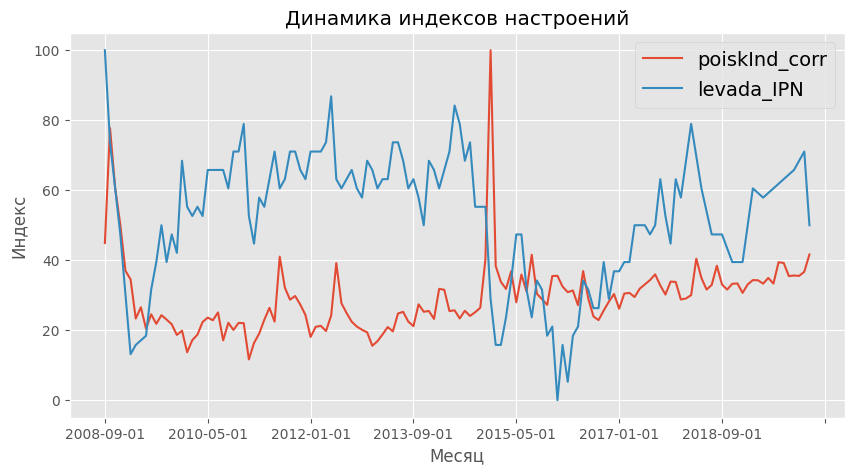

In [ ]:
df[['poiskInd_corr', 'levada_IPN']].plot(figsize=(10,5));

plt.title('Динамика индексов настроений');
plt.xlabel("Месяц")
plt.ylabel("Индекс")
plt.legend(fontsize=14);

Видно, что в период кризиса индекс доверия Левады падает. Индекс обеспокоенности, построенный по гуглу, растёт.

# 3. Предварительный анализ рядов

Изучу более тщательно изменения в курсе валюты и величине продаж в розничной торговле.

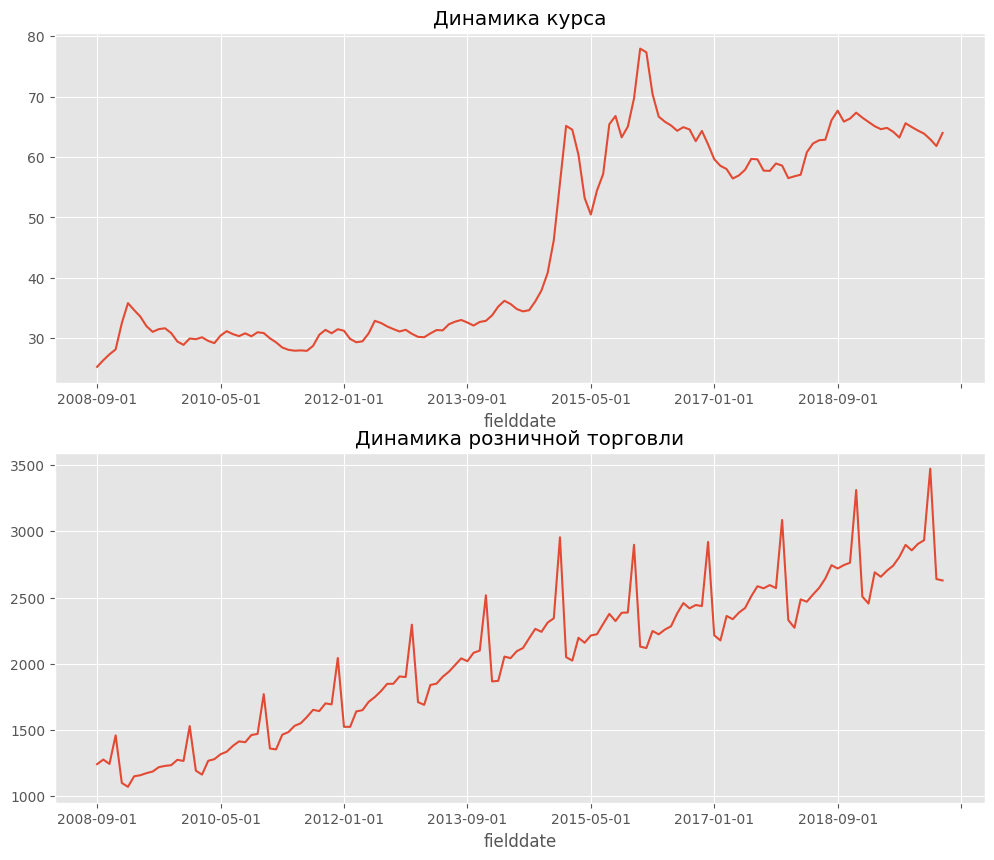

In [ ]:
_, axes = plt.subplots(2, 1, figsize=(12,10))

df['USD'].plot(ax=axes[0]);
df['RTRD'].plot(ax=axes[1]);

axes[0].set_title("Динамика курса")
axes[1].set_title("Динамика розничной торговли");

Можно заметить, что динамика валютного курса нестационарна. В этом временном ряду присутствуют два различных средних значения, но ни тренда, ни сезонных колебаний не заметно.

В то же время, в показателях розничной торговли заметен явный тренд и сезонные колебания.

Проверим гипотезу о стационарности рядов с помощью KPSS и ADF тестов, учитвая что в динамике розничной торговли есть константа и тренд. В динамике курса есть константа.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

alpha = 0.05

pval_usd_kpss = kpss(df['USD'], regression='c')[1]
pval_rtrd_kpss = kpss(df['RTRD'], regression='ct')[1]
pval_usd_adf = adfuller(df['USD'], regression='c')[1]
pval_rtrd_adf = adfuller(df['RTRD'], regression='ct', autolag='AIC')[1]

print(f"KPSS Test for USD (p-value): {pval_usd_kpss:.4f} {'Stationary' if pval_usd_kpss > alpha else 'Non-stationary'}")
print(f"KPSS Test for RTRD (p-value): {pval_rtrd_kpss:.4f} {'Stationary' if pval_rtrd_kpss > alpha else 'Non-stationary'}")
print(f"ADF Test for USD (p-value): {pval_usd_adf:.4f} {'Stationary' if pval_usd_adf < alpha else 'Non-stationary'}")
print(f"ADF Test for RTRD (p-value): {pval_rtrd_adf:.4f} {'Stationary' if pval_rtrd_adf < alpha else 'Non-stationary'}")


KPSS Test for USD (p-value): 0.0100 Non-stationary
KPSS Test for RTRD (p-value): 0.0100 Non-stationary
ADF Test for USD (p-value): 0.7791 Non-stationary
ADF Test for RTRD (p-value): 0.3853 Non-stationary


<ipython-input-9-8f978150b277>:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  pval_usd_kpss = kpss(df['USD'], regression='c')[1]
<ipython-input-9-8f978150b277>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  pval_rtrd_kpss = kpss(df['RTRD'], regression='ct')[1]


Оба ряда оказались на уровне значимости $10\%$ нестационарными по всем тестам.

Чтобы привести ряды к стационарности попробуем взять первую разность от валютного курса. Для оборота розничной торговли возьмем $12$-ую, сезонную разность и изобразим динамику разностей на картике.

In [ ]:
df['USD_diff'] = df['USD'].diff()
df = df.dropna(subset=['USD_diff'])
df['USD_diff'].head()

fielddate
2008-10-01    1.086445
2008-11-01    0.977322
2008-12-01    0.817573
2009-01-01    4.340980
2009-02-01    3.322142
Name: USD_diff, dtype: float64

In [ ]:
df['RTRD_diff'] = df['RTRD'].diff(12)
df = df.dropna(subset=['RTRD_diff'])
df['RTRD_diff'].head()

<ipython-input-43-8950347fd974>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RTRD_diff'] = df['RTRD'].diff(12)


fielddate
2009-10-01    -2.0
2009-11-01    22.5
2009-12-01    69.8
2010-01-01    92.6
2010-02-01    92.1
Name: RTRD_diff, dtype: float64

In [ ]:
pval_diff_usd = adfuller(df['USD_diff'], regression='n', autolag='AIC')[1]
pval_diff_rtrd = adfuller(df['RTRD_diff'], regression='c', autolag='AIC')[1]

print(f"ADF Test for USD_diff (p-value): {pval_diff_usd:.4f} - {'Stationary' if pval_diff_usd < 0.1 else 'Non-stationary'}")
print(f"ADF Test for RTRD_diff (p-value): {pval_diff_rtrd:.4f} - {'Stationary' if pval_diff_rtrd < 0.1 else 'Non-stationary'}")


ADF Test for USD_diff (p-value): 0.0000 - Stationary
ADF Test for RTRD_diff (p-value): 0.0734 - Stationary


Для обоих рядов гипотеза о наличии единичного корня отвергается.


Давайте более тщательно проанализируем изменения в разностях курса валюты. Особенно заметно, что в период 2014-2015 годов изменчивость курса была значительно выше, что, вероятно, связано с валютным кризисом и переориентацией Центрального Банка на контроль инфляции. Такие колебания в дисперсии могут нарушить предположения, необходимые для модели ARIMA, что в свою очередь повлияет на точность доверительных интервалов. Один из способов устранения этого недостатка - использование преобразования Бокса-Кокса для стабилизации дисперсии.

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.1 MB/s eta 0:00:00


In [ ]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

transformer = BoxCoxEndogTransformer()
transformer.fit(df['USD'])
df['USD_transformed'], _ = transformer.fit_transform(df['USD'])

In [ ]:
df['USD_transformed_diff'] = df['USD_transformed'].diff()
df = df.dropna(subset=['USD_transformed_diff'])
df['USD_transformed_diff'].head()

fielddate
2009-11-01   -0.024597
2009-12-01    0.045960
2010-01-01   -0.005158
2010-02-01    0.013657
2010-03-01   -0.025718
Name: USD_transformed_diff, dtype: float64

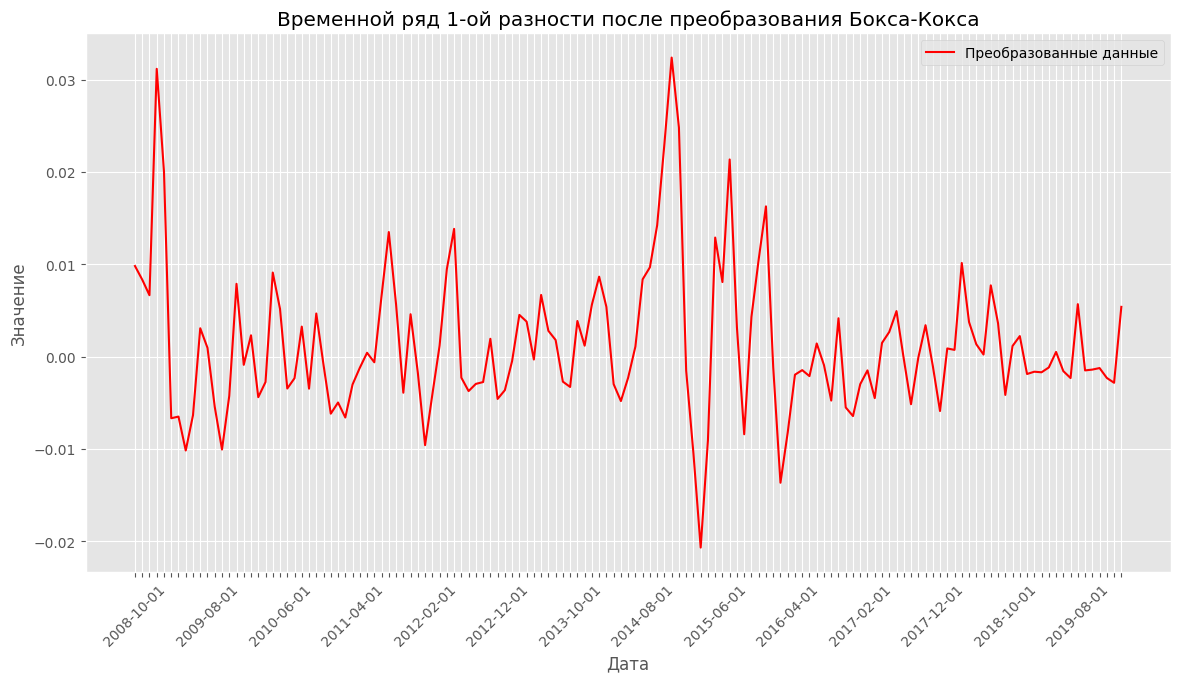

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['USD_transformed_diff'], label='Преобразованные данные', color='red')
plt.title('Временной ряд 1-ой разности после преобразования Бокса-Кокса')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()


x_axis = plt.gca().xaxis
for i, tick in enumerate(x_axis.get_ticklabels()):
    if i % 10 != 0:
        tick.set_visible(False)

plt.show()

# 4. ARIMA-модель

Давайте разделим наш набор данных на две части: одну для обучения и другую для тестирования модели ARIMA.

1. Параметры `p,q` будем перебирать от 0 до 5 включительно, `P,Q` от 1 до 3
2. Параметр `seasonal` поставим в `true` с `m=12`
3. Параметры `max_D, max_d` поставим равным 2, поскольку смысл взятиея производных более 2 раз не определен.
4. Параметр `max_order` выставим в 10
5. В поле `information_criterion` выберем для выбора моделей критерий Шварца (`bic`)
6. Выставим `stepwise=True`. Это специальный алгоритм для более быстрого перебора гипер-параметров

In [ ]:
import pmdarima as pm

def train_arima(y, test_size=36):
    y_train, y_test = y[:-test_size], y[-test_size:]

    arima_model = pm.auto_arima(
        y_train,

        start_p = 0, start_q = 0,
        max_p = 5, max_q = 5,

        start_P = 0, start_Q = 0,
        max_P = 3, max_Q = 3,

        seasonal = True, m = 12,

        max_d = 2, max_D = 2,

        max_order = 10,

        information_criterion = 'bic',

        stepwise=True,

        trace=True)

    return arima_model

In [ ]:
model_rtrd = train_arima(df.RTRD.values)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=940.219, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=939.174, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=935.187, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=930.699, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=935.187, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=939.675, Time=0.26 sec
 ARIMA(1,1,1)(0,1,0)[12]             : BIC=935.035, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[12]             : BIC=934.982, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=934.686, Time=0.09 sec
 ARIMA(1,1,2)(0,1,0)[12]             : BIC=939.096, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : BIC=935.127, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 1.465 seconds


In [ ]:
model_usd = train_arima(df.USD.values)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=423.908, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=398.185, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=379.405, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=420.892, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : BIC=384.396, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : BIC=383.592, Time=0.68 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : BIC=383.558, Time=1.87 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : BIC=380.912, Time=0.62 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : BIC=388.018, Time=2.26 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : BIC=417.100, Time=0.23 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : BIC=383.265, Time=0.69 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : BIC=383.420, Time=0.39 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=395.434, Time=0.19 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : BIC=387.293, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[12]         

In [ ]:
model_rtrd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  102
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -460.861
Date:                             Thu, 07 Dec 2023   AIC                            925.721
Time:                                     16:06:07   BIC                            930.699
Sample:                                          0   HQIC                           927.728
                                             - 102                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4327      0.046     -9.391      0.000      -0.523      -0.342
sigma2      1838.1502    137.024     13.415      0.000    1569.588    2106.712
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               176.15
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               4.10   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_usd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   88
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                 141.881
Date:                            Thu, 07 Dec 2023   AIC                           -277.763
Time:                                    16:15:36   BIC                           -270.331
Sample:                                         0   HQIC                          -274.769
                                             - 88                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9315      0.062     14.982      0.000       0.810       1.053
ma.S.L12       0.2532      0.152      1.668      0.095      -0.044       0.551
sigma2         0.0023      0.000      8.485      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   1.25   Jarque-Bera (JB):                13.18
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               4.71   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Построим протоколы для диагностики получившихся моделей. Заметим, что для обеих модлей гистограмма вместе с кривой KDE напоминают форму нормального распределения, на королелограмме большинство точек находятся внутри границ, указывая на отсутствие заметной автокорреляции, однако остатки кажутся довольно волатильными и имеют некоторые выбросы. Модель в целом может быть использована для прогнозирования, но доверительные интервалы могут быть менее точными из-за ненормальности остатков.

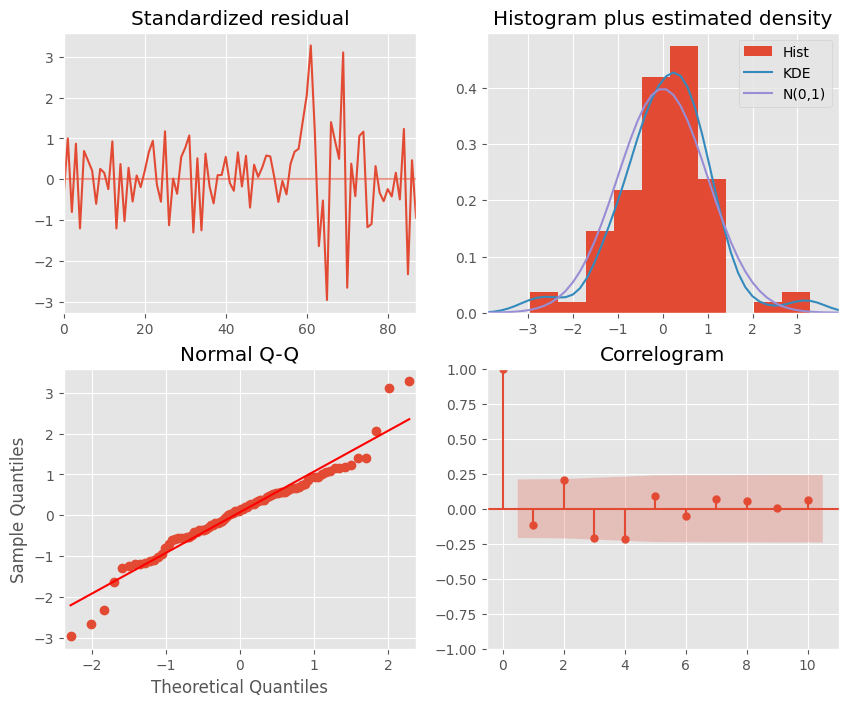

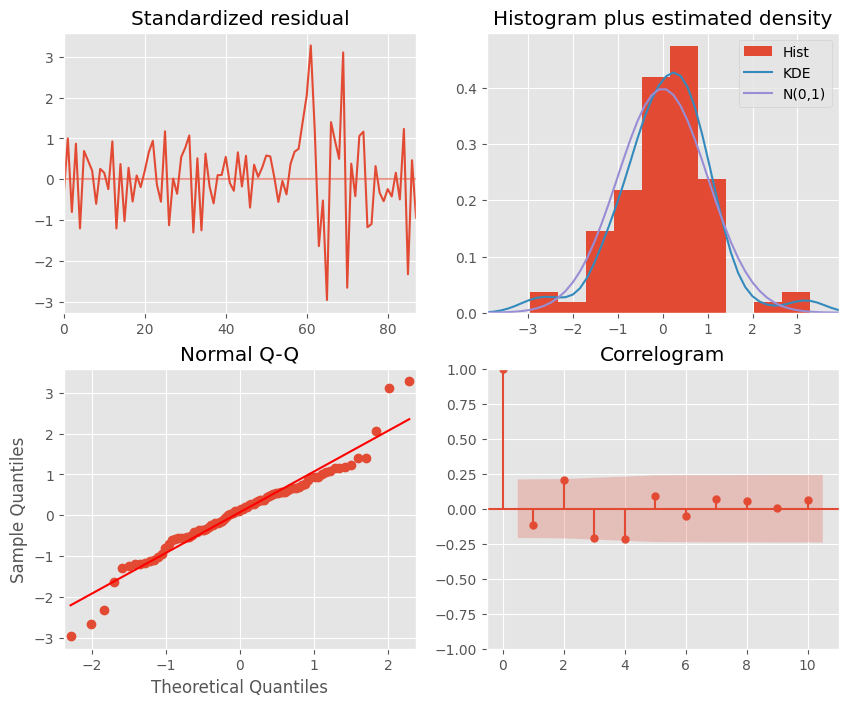

In [ ]:
model_usd.plot_diagnostics(figsize=(10, 8))

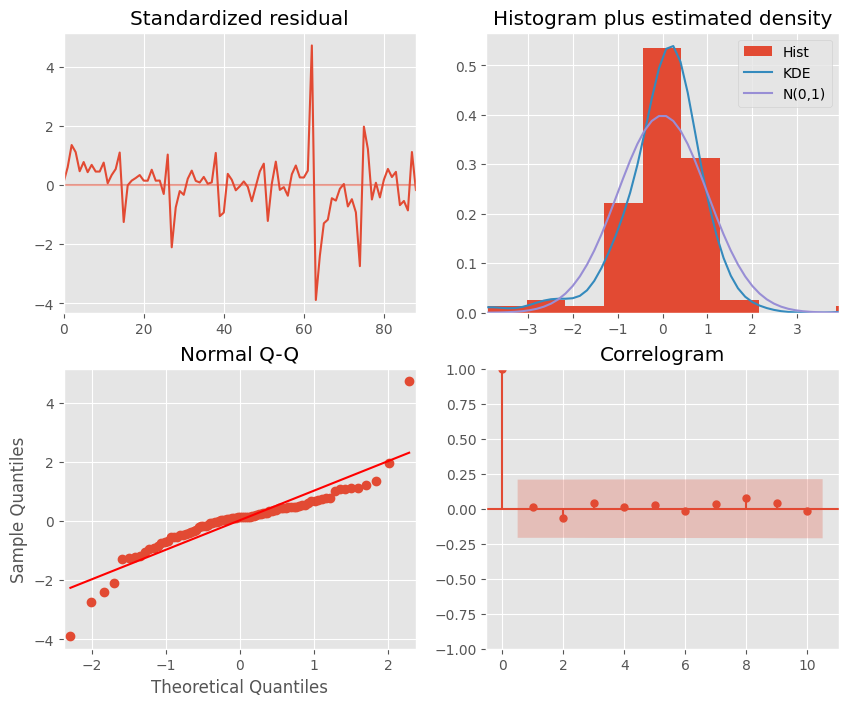

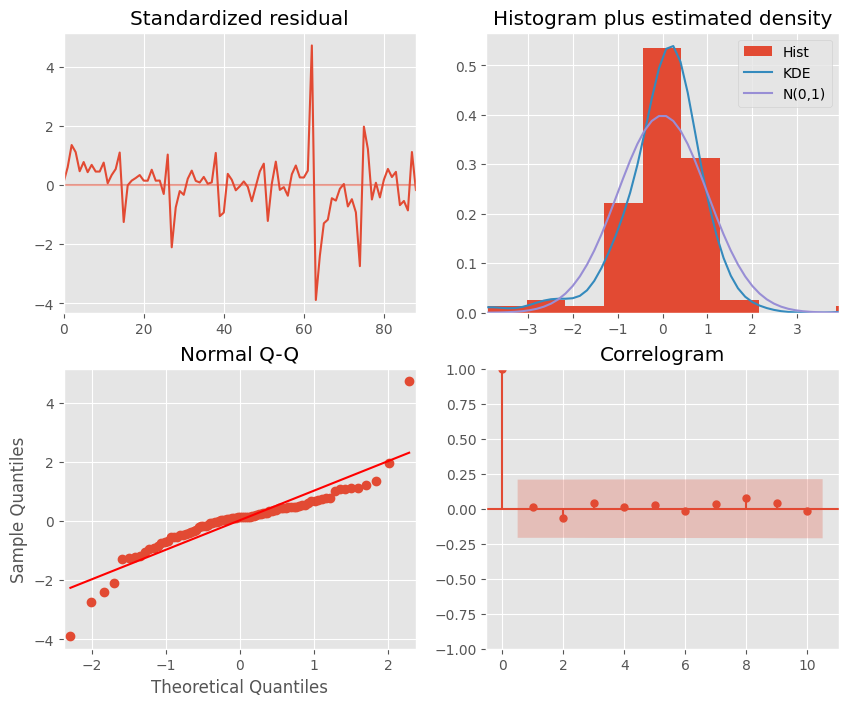

In [ ]:
model_rtrd.plot_diagnostics(figsize=(10, 8))

Построим Leave One Out прогнозы

In [ ]:
from pmdarima import model_selection

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def loo_cv(model, y, test_size=36):

    y_train, y_test = y[:-test_size], y[-test_size:]

    cv = model_selection.SlidingWindowForecastCV(
        window_size=y_train.size,
        step=1,
        h=1
    )

    predicts_noIndex = model_selection.cross_val_predict(
        model, y,
        cv = cv,
    )

    return predicts_noIndex, mae(y_test, predicts_noIndex)

Построим прогнозы для курса доллара и оборота розничной торговли и замерим качество получившихся прогнозов с помощью метрики MAE.

In [ ]:
pred1, mae_usd = loo_cv(model_usd, df['USD'])
pred2, mae_rtrd = loo_cv(model_rtrd, df['RTRD'])

print(f"MAE для модели USD: {mae_usd:.4f}")
print(f"MAE для модели RTRD: {mae_rtrd:.4f}")


MAE для модели USD: 1.3861
MAE для модели RTRD: 18.7592


In [ ]:
!pip3 install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 14.8 MB/s eta 0:00:00


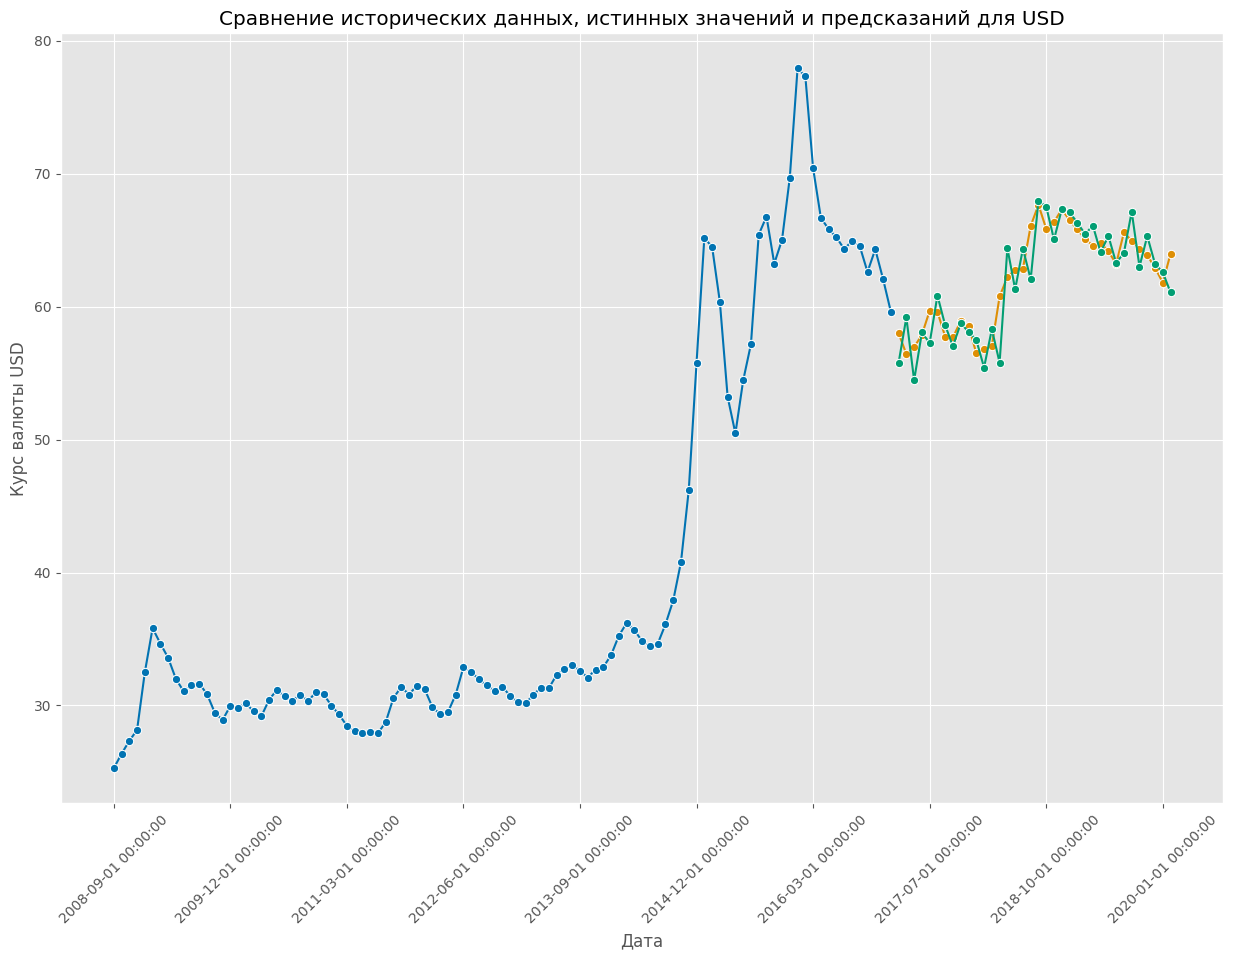

In [ ]:
from sktime.utils.plotting import plot_series

df_pred = pd.Series(pred1, index = df.index[-36:])
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots(figsize=(15, 10))
plot_series(df['USD'][:-37], df['USD'][-36:], df_pred, ax=ax)

plt.xticks(rotation=45)

plt.title('Сравнение исторических данных, истинных значений и предсказаний для USD')
plt.xlabel('Дата')
plt.ylabel('Курс валюты USD')

plt.show()



# 5. ARIMA с экзогенными переменными

Теперь добавим в качестве экзогенной переменной в нашу модель лаги индексов неопределённости. Если бы у нас была модель $ARMA(1,1)$ и мы бы захотели добавить в неё экзогенную переменную $x_{t-1}$, модель выглядела бы так:

$$
y_t = \mu + \beta \cdot  y_{t-1} + \alpha \cdot \varepsilon_{t-1} + \varepsilon_t + \gamma \cdot x_{t-1}
$$



In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))


def custom_loo_cv(y, x, order, seasonal_order, test_size):
    preds = []
    test_ys = []  # Для хранения всех тестовых значений

    n = len(y)

    for i in range(n - test_size):
        train_y, test_y = y[:i + test_size], y[i + test_size:i + test_size + 1]
        train_x, test_x = x[:i + test_size], x[i + test_size:i + test_size + 1]

        model = SARIMAX(train_y, exog=train_x, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=0)

        forecast = model_fit.forecast(steps=1, exog=test_x)
        preds.append(forecast[0])
        test_ys.append(test_y[0])  # Сохраняем тестовое значение

    return preds, mae(test_ys, preds)  # Вычисляем MAE для всех прогнозов



In [ ]:
order = (0, 1, 1)
seasonal_order = (0, 1, [], 12)


In [ ]:
y = df.RTRD.values
x = df.levada_IPN.values


predictions, mae_rtrd_2 = custom_loo_cv(y, x, order, seasonal_order, test_size=36)

In [ ]:
y = df.RTRD.values
x = df.poiskInd_corr.values

predicts_poisk_rtrd, mae_rtrd_3 = custom_loo_cv(y, x, order, seasonal_order, test_size=36)

In [ ]:
print(f'Оригинальная модель: {mae_rtrd}')
print(f'Модель с индексом Левады: {mae_rtrd_2}')
print(f'Модель с индексом поиска: {mae_rtrd_3}')

Оригинальная модель: 18.75921820042888
Модель с индексом Левады: 27.112370174456267
Модель с индексом поиска: 22.942537600475607


Оба индекса ихудшают прогноз оборота розничной торговли. Попробуем посмотреть, получится ли у нас предсказывать по текущему значению индекса будущее значение оборота розничной торговли. Попробуем посмотреть, получится ли у нас предсказывать по текущему значению индекса будущее значение оборота розничной торговли.

In [ ]:
y = df.RTRD.values[1:]
x = df.levada_IPN.shift(1).values[1:]
predicts_levada_rtrd, mae_rtrd_2 = custom_loo_cv(y, x, order, seasonal_order, test_size=36)

In [ ]:
y = df.RTRD.values[1:]
x = df.poiskInd_corr.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

predicts_poisk_rtrd, mae_rtrd_3 = custom_loo_cv(y, x, order, seasonal_order, test_size=36)

In [ ]:
print(f'Оригинальная модель: {mae_rtrd}')
print(f'Модель с индексом Левады: {mae_rtrd_2}')
print(f'Модель с индексом поиска: {mae_rtrd_3}')

Оригинальная модель: 18.75921820042888
Модель с индексом Левады: 28.104958878127924
Модель с индексом поиска: 27.954111697515476


Видно, что оба индекса снова ухудшили прогнозы :(

###  Курс валюты

Проделаем такую же операцию с валютным курсом.

In [ ]:
y = df.USD.values
x = df.levada_IPN.values
seasonal_order = (0, 0, 1, 12)
predicts_levada_usd, mae_usd_2 = custom_loo_cv(y, x, order, seasonal_order, test_size=36)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
y = df.USD.values
x = df.poiskInd_corr.values

predicts_poisk_usd, mae_usd_3 = custom_loo_cv(y, x, order, seasonal_order, test_size=36)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
print(f'Оригинальная модель: {mae_usd}')
print(f'Модель с индексом Левады: {mae_usd_2}')
print(f'Модель с индексом поиска: {mae_usd_3}')

Оригинальная модель: 1.3861217978440532
Модель с индексом Левады: 1.4232925078441003
Модель с индексом поиска: 1.497618564027339


Попробуем посмотреть, можно ли прогнозировать курс с помощью запаздывания лучше, чем обычной ARIMA.

In [ ]:
y = df.USD.values[1:]
x = df.levada_IPN.shift(1).values[1:]

predicts_levada_usd, mae_usd_2 = custom_loo_cv(y, x, order, seasonal_order, test_size=36)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
y = df.USD.values[1:]
x = df.poiskInd_corr.shift(1).values[1:]

predicts_poisk_usd, mae_usd_3 = custom_loo_cv(y, x, order, seasonal_order, test_size=36)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
print(f'Оригинальная модель: {mae_usd}')
print(f'Модель с индексом Левады: {mae_usd_2}')
print(f'Модель с индексом поиска: {mae_usd_3}')

Оригинальная модель: 1.3861217978440532
Модель с индексом Левады: 1.4760006686266092
Модель с индексом поиска: 1.5076524288418731


Видно, что оба индекса не улучшили прогнозы.

Попробуйте, по аналогии с тем, что было сделано выше, добавить в модель в качестве экзогенных переменных сразу оба индекса.

In [ ]:
def custom_loo_cv(y, x, z, order, seasonal_order, test_size):
    preds = []
    errors = []
    n = len(y)

    if x.ndim == 1:
        x = x.reshape(-1, 1)
    if z.ndim == 1:
        z = z.reshape(-1, 1)

    exog = np.hstack((x, z))

    for i in range(n - test_size, n - 1):
        train_y, test_y = y[:i + 1], y[i + 1:i + 2]
        train_exog, test_exog = exog[:i + 1], exog[i + 1:i + 2]

        model = SARIMAX(train_y, exog=train_exog, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=0)

        forecast = model_fit.forecast(steps=1, exog=test_exog)
        preds.append(forecast[0])
        errors.append(test_y[0] - forecast[0])

    mae = np.mean(np.abs(errors))
    return preds, mae





y = df.USD.values
x = df.levada_IPN.values
z = df.poiskInd_corr.values
order = (0, 1, 1)
seasonal_order = (0, 0, 1, 12)
predicts_levada_usd, mae_usd = custom_loo_cv(y, x, z, order, seasonal_order, test_size=36)

mae_usd

1.3188142690023292

In [ ]:
def custom_loo_cv(y, x, z, order, seasonal_order, test_size):
    preds = []
    errors = []
    n = len(y)

    if x.ndim == 1:
        x = x.reshape(-1, 1)
    if z.ndim == 1:
        z = z.reshape(-1, 1)

    exog = np.hstack((x, z))

    for i in range(n - test_size, n - 1):
        train_y, test_y = y[:i + 1], y[i + 1:i + 2]
        train_exog, test_exog = exog[:i + 1], exog[i + 1:i + 2]

        model = SARIMAX(train_y, exog=train_exog, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=0)

        forecast = model_fit.forecast(steps=1, exog=test_exog)
        preds.append(forecast[0])
        errors.append(test_y[0] - forecast[0])

    mae = np.mean(np.abs(errors))
    return preds, mae





y = df.RTRD.values
x = df.levada_IPN.values
z = df.poiskInd_corr.values
order = (0, 1, 1)
seasonal_order = (0, 1, [], 12)
predicts_levada_usd, mae_rtrd = custom_loo_cv(y, x, z, order, seasonal_order, test_size=36)

mae_rtrd

20.86695901378979

Мы улучшили прогноз для USD по сравнению с обычной  ARIMA моделью! Ура! :)



__Выводы:__ индексы поиска и Левады содержут информацию о том, что в данный момент происходит в экономике. Их текущее значение помогает предсказать, что происходит прямо сейчас в экономике. На практике это бесполезно. Мы хотим по вчерашнему значению индекса спрогнозировать, что произойдет завтра. Видно, что это можно сделать для курса доллара с помощью включения обоих индексов

__Мысли для дальнейшей работы:__ Вообще говоря, данные у нас месячные. Если бы частота данных была бы повыше, эффект от добавления индексов в модели мог бы быть сильнее. Это хорошая почва для размышления для отдельного исследования